# Dogs vs Cats

https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition

In [1]:
import cv2
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.applications import vgg16

from zipfile import ZipFile

In [2]:
with ZipFile('/content/drive/MyDrive/БД/cats_vs_dogs/train_all.zip', 'r') as archive:
    archive.extractall('/content/sample_data/Train')

In [3]:
with ZipFile('/content/drive/MyDrive/БД/cats_vs_dogs/test_all.zip', 'r') as archive:
    archive.extractall('/content/sample_data/Test')

## Функции загрузки данных

In [4]:
import os
from random import shuffle
from glob import glob

IMG_SIZE = (224, 224)  # размер входного изображения сети

train_files = glob('/content/sample_data/Train/*.jpg')
test_files = glob('/content/sample_data/Test/*.jpg')

# загружаем входное изображение и предобрабатываем
def load_image(path, target_size=IMG_SIZE):
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, target_size)
    return vgg16.preprocess_input(img)  # предобработка для VGG16

# функция-генератор загрузки обучающих данных с диска
def fit_generator(files, batch_size=32):
    batch_size = min(batch_size, len(files))
    while True:
        shuffle(files)
        for k in range(len(files) // batch_size):
            i = k * batch_size
            j = i + batch_size
            if j > len(files):
                j = - j % len(files)
            x = np.array([load_image(path) for path in files[i:j]])
            y = np.array([1. if os.path.basename(path).startswith('dog') else 0.
                          for path in files[i:j]])
            yield (x, y)

# функция-генератор загрузки тестовых изображений с диска
def predict_generator(files):
    while True:
        for path in files:
            yield np.array([load_image(path)])

def loss_plot(m):
    plt.plot(m.history['loss'], label='train loss')
    plt.plot(m.history['val_loss'], label='val_loss')
    plt.legend()
    plt.show()

## Визуализируем примеры для обучения

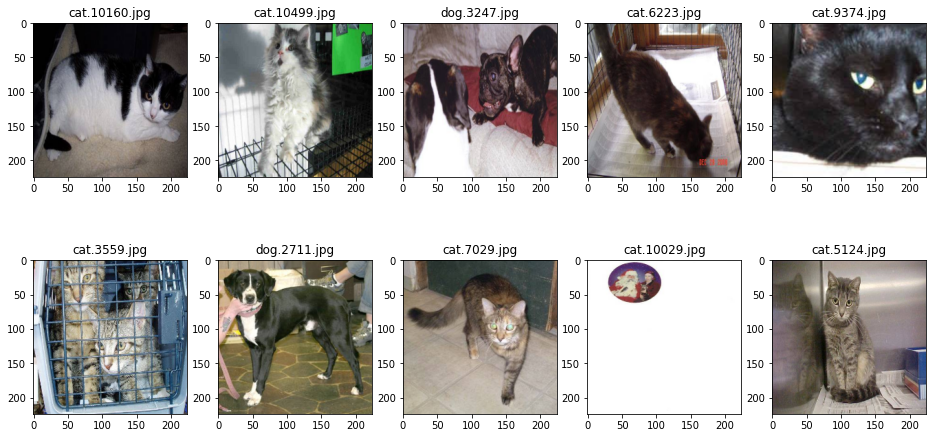

In [5]:
%matplotlib inline
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(16, 8))
for i, path in enumerate(train_files[:10], 1):
    subplot = fig.add_subplot(2, 5, i)
    subplot.set_title('%s' % path.split('/')[-1])
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, IMG_SIZE)
    plt.imshow(img)

## Загружаем предобученную модель

In [6]:
# base_model - объект класса keras.models.Model (Functional Model)
base_model = vgg16.VGG16(weights='imagenet',
                         include_top=False,
                         input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

In [7]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     



## Добавляем BatchNormalization и полносвязный слой.

In [8]:
# фиксируем все веса предобученной сети
for layer in base_model.layers:
    layer.trainable = False

x = base_model.layers[-1].output
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(1,  # один выход (бинарная классификация)
                          activation='sigmoid',  # функция активации
                          )(x)

model = tf.keras.Model(inputs=base_model.input, outputs=x, name='dogs_vs_cats')

## Выводим архитектуру модели

In [9]:
model.summary()

Model: "dogs_vs_cats"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

## Компилируем модель и запускаем обучение

In [10]:
model.compile(optimizer='sgd', 
              loss='binary_crossentropy',  # функция потерь binary_crossentropy (log loss
              metrics=['accuracy'])

In [11]:
val_samples = 5  # число изображений в валидационной выборке

shuffle(train_files)  # перемешиваем обучающую выборку
validation_data = next(fit_generator(train_files[:val_samples], val_samples))
train_data = fit_generator(train_files[val_samples:])  # данные читаем функцией-генератором

# запускаем процесс обучения
m = model.fit(train_data,
          steps_per_epoch=10,  # число вызовов генератора за эпоху
          epochs=100,  # число эпох обучения
          validation_data=validation_data)

Epoch 1/100
10/10 [==============================] - 7s 279ms/step - loss: 0.5784 - accuracy: 0.7239 - val_loss: 0.0709 - val_accuracy: 1.0000
Epoch 2/100
10/10 [==============================] - 2s 160ms/step - loss: 0.1614 - accuracy: 0.9271 - val_loss: 0.4262 - val_accuracy: 0.8000
Epoch 3/100
10/10 [==============================] - 2s 156ms/step - loss: 0.1046 - accuracy: 0.9673 - val_loss: 0.4799 - val_accuracy: 0.8000
Epoch 4/100
10/10 [==============================] - 2s 164ms/step - loss: 0.1317 - accuracy: 0.9570 - val_loss: 0.2046 - val_accuracy: 0.8000
Epoch 5/100
10/10 [==============================] - 2s 161ms/step - loss: 0.1254 - accuracy: 0.9504 - val_loss: 0.0671 - val_accuracy: 1.0000
Epoch 6/100
10/10 [==============================] - 2s 157ms/step - loss: 0.1068 - accuracy: 0.9558 - val_loss: 0.1339 - val_accuracy: 1.0000
Epoch 7/100
10/10 [==============================] - 2s 165ms/step - loss: 0.0716 - accuracy: 0.9789 - val_loss: 0.1894 - val_accuracy: 0.8000

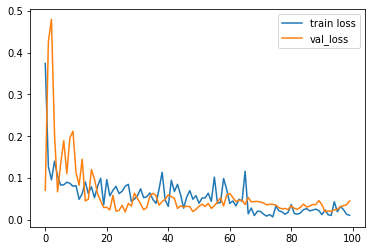

In [12]:
loss_plot(m)

## Сохраним модель

In [20]:
model.save('/content/drive/MyDrive/БД/cats_vs_dogs/cats-dogs-vgg16.hdf5')

## Предсказания на проверочной выборке

In [13]:
test_pred = model.predict(predict_generator(test_files), steps=len(test_files))

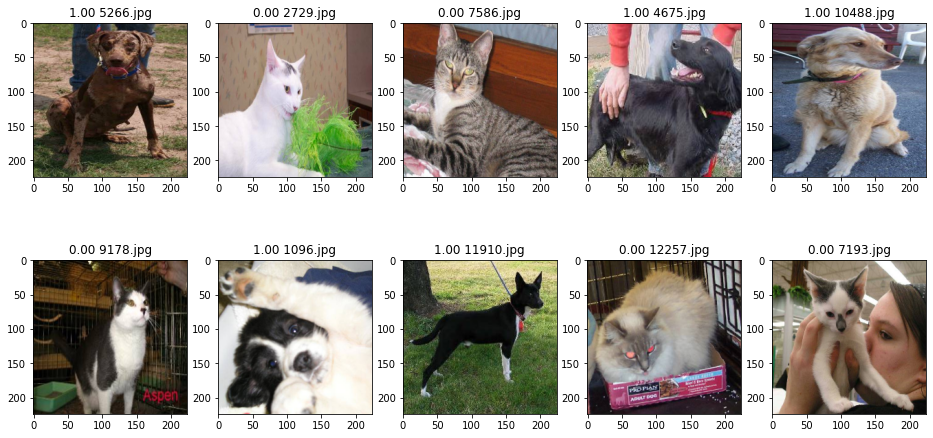

In [14]:
fig = plt.figure(figsize=(16, 8))
for i, (path, score) in enumerate(zip(test_files[:10], test_pred[:10]), 1):
    subplot = fig.add_subplot(2, 5, i)
    subplot.set_title('%.2f %s' % (score, os.path.basename(path)))
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, IMG_SIZE)
    subplot.imshow(img)

## Готовим данные для отправки

In [17]:
import re

with open('/content/drive/MyDrive/БД/cats_vs_dogs/submition.csv', 'w') as dst:
    dst.write('id,label\n')
    for path, score in zip(test_files, test_pred):
        dst.write('%s,%f\n' % (re.search('(\d+).jpg$', path).group(1), score))

## Результат оценки работы модели на test-выборке на Kaggle.

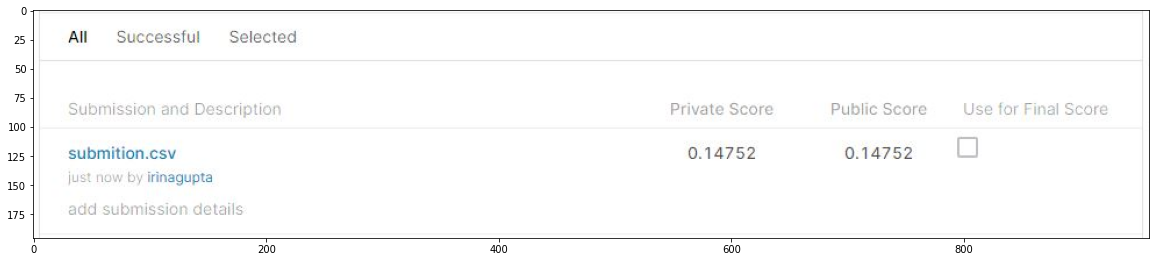

In [19]:
img_cv = cv2.imread('/content/drive/MyDrive/БД/cats_vs_dogs/Submission.JPG')
img_rgb = cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(20, 10))
plt.imshow(img_rgb)